# Lab 1: DNN Computations, Einsums, and Introduction to AccelForge
Due date: 02/23/2026

## Learning Objectives
This lab aims to overview DNNs, Einsums, and analysis of Einsums (e.g., rank shapes,
tensor shapes, number of operations, operational intensity).
Finally, we will introduce an important tool for this class, AccelForge, which you will be using to model
and design accelerators.


## Section 0: Biographical Information
Please enter your biographical information below so we may assign you a grade for your work. This cell additionally imports the library the Jupyter notebook uses to serialize your answers so we can grade them for your convenience.

In [1]:
from loaders import answer, AnswerMe
from numbers import Number
from typing import List
import matplotlib.pyplot as plt
from IPython.display import display, Math

answer(
    question="0.0",
    subquestion=f"What is your name?",
    required_type=str,
    answer= 'Claude',
)
answer(
    question="0.1",
    subquestion=f"What is your email address?",
    required_type=str,
    answer= 'claude@mit.edu',
)
answer(
    question="0.2",
    subquestion=f"What is your kerberos?",
    required_type=str,
    answer= 'claude',
)

0.0: What is your name?
	Claude
0.1: What is your email address?
	claude@mit.edu
0.2: What is your kerberos?
	claude


## Section 1: DNN Refresher
In this section, we will review some computations used in DNNs by implementing them in Python.

### Question 1: Fully-connected Layer
We will write a fully-connected layer as an Einsum and implement it in Python.

We will define a fully-connected layer as performing the following computation (expressed in a traditional algebraic notation):
$$
O[n, m] = \sum_{chw=0}^{CHW-1}{I[n, chw] \times F[chw, m]} + B[m] \forall 0 \leq n < N, 0 \leq m < M
$$

Please assign values to the following rank variables such that the displayed Einsum correctly represents a fully-connected layer.

In [2]:
rank_variable_1 = "n"
rank_variable_2 = "m"
rank_variable_3 = "n"
rank_variable_4 = "chw"
rank_variable_5 = "chw"
rank_variable_6 = "m"
rank_variable_7 = "m"
########################
#### YOUR CODE HERE ####
########################

print("Your fully-connected Einsum:")
your_fc_einsum = (
    f"O_{{ {rank_variable_1}, {rank_variable_2} }} = I_{{ {rank_variable_3}, {rank_variable_4} }} \\times "
    +
    f"F_{{ {rank_variable_5}, {rank_variable_6} }} + B_{{ {rank_variable_7} }}"
)
display(Math(your_fc_einsum))

answer(
    "1.1.1",
    "Your fully-connected Einsum.",
    required_type=str,
    answer=your_fc_einsum,
)

Your fully-connected Einsum:


<IPython.core.display.Math object>

1.1.1: Your fully-connected Einsum.
	O_{ n, m } = I_{ n, chw } \times F_{ chw, m } + B_{ m }


Now, please implement the Einsum in Python below.

In [3]:
def fc(I: List[List[int]], F: List[List[int]], B: List[int]) -> List[List[int]]:
    """
    Compute a fully-connected layer with input I, filter weights F, and bias B.

    Rank names are
            N: batch size
            M: output channels
            CHW: flattened input channel, height, and width of a convolution.

    Multi-dimensional lists are represented as nested lists. E.g., the 2D list
    `I` has
    ```
    len(I) == N
    len(I[n]) == CHW, for 0 <= n < N
    ```

    Parameters
    ----------
    I:
            Input to the fully-connected layer, a N x CHW list.
    F:
            Filter weights, a CHW x M list.
    B:
            Bias, a 1D list with shape M.

    Returns
    -------
    The output of the fully-connected layer as a N x M list.
    """
    # Rank shapes
    M: int = len(F[0])
    N: int = len(I)
    CHW: int = len(I[0])


    # Initialize the output O, an N x M array, with the bias
    O: list[list[int]] = [[0]*M for _ in range(N)]
    for n in range(N):
        for m in range(M):
            O[n][m] = B[m]

    # TODO: Using only base Python operators (i.e., not invoking any libraries) please
    # implement a fully-connected layer. Note that if there are any unneeded imports,
    # you will receive a zero for this question.
    for n in range(N):
        for m in range(M):
            for chw in range(CHW):
                O[n][m] += I[n][chw] * F[chw][m]
    ########################
    #### YOUR CODE HERE ####
    ########################

    return O


input = [
#   +----CHW----+
    [1, 2, 3, 4],  # Batch = 0
    [5, 6, 7, 8],  # Batch = 1
]
weight = [
#   +---M---+
    [1, 2, 3],  #  T
    [4, 5, 6],  # CHW
    [7, 8, 9],  #  |
    [10, 11, 12],  #  _|_
]
#      +----M---+
bias = [1, 2, 3]

expected = [[71, 82, 93], [159, 186, 213]]

if fc(input, weight, bias) != expected:
    print(f"Warning! FC implementation is incorrect!")

answer(
    question="1.1.2",
    subquestion=f"What is your fc implementation?",
    required_type=callable,
    answer=fc,
)

1.1.2: What is your fc implementation?
	{'callable': 'fc', 'source': 'def fc(I: List[List[int]], F: List[List[int]], B: List[int]) -> List[List[int]]:\n    """\n    Compute a fully-connected layer with input I, filter weights F, and bias B.\n\n    Rank names are\n            N: batch size\n            M: output channels\n            CHW: flattened input channel, height, and width of a convolution.\n\n    Multi-dimensional lists are represented as nested lists. E.g., the 2D list\n    `I` has\n    ```\n    len(I) == N\n    len(I[n]) == CHW, for 0 <= n < N\n    ```\n\n    Parameters\n    ----------\n    I:\n            Input to the fully-connected layer, a N x CHW list.\n    F:\n            Filter weights, a CHW x M list.\n    B:\n            Bias, a 1D list with shape M.\n\n    Returns\n    -------\n    The output of the fully-connected layer as a N x M list.\n    """\n    # Rank shapes\n    M: int = len(F[0])\n    N: int = len(I)\n    CHW: int = len(I[0])\n\n\n    # Initialize the outpu

### Question 2: Convolution Layer
We will define a convolution layer as performing the following computation (expressed in a traditional algebraic expression):
$$
O[n, m, p, q] = \sum_{r=0,s=0,c=0}^{R-1, S-1, C-1}{I[n, c, p+r, q+s] \times F[c, m, r, s]} + B[m] \\ \forall 0 \leq n < N, 0 \leq m < M, 0 \leq p < P, 0 \leq q < Q
$$

Like the previous question, please fill in the following rank names and rank variables such that the correct Einsum for convolutions is produced.

In [4]:
rank_1 = "P+R-1"
rank_2 = "Q+S-1"
rank_variable_1 = "p"
rank_variable_2 = "q"
rank_variable_3 = "p+r"
rank_variable_4 = "q+s"
rank_variable_5 = "r"
rank_variable_6 = "s"
rank_variable_7 = "m"
########################
#### YOUR CODE HERE ####
########################

print("Your convolution Einsum:")
your_conv_einsum = (
    f"O_{{ n, m, {rank_variable_1}, {rank_variable_2} }} = I_{{ n, c, {rank_variable_3}, {rank_variable_4} }}^{{ N, C, {rank_1}, {rank_2} }} \\times "
    +
    f"F_{{ c, m, {rank_variable_5}, {rank_variable_6} }} + B_{{ {rank_variable_7} }}"
)
display(Math(your_conv_einsum))

answer(
    "1.2.1",
    "Your conv Einsum.",
    required_type=str,
    answer=your_conv_einsum,
)

Your convolution Einsum:


<IPython.core.display.Math object>

1.2.1: Your conv Einsum.
	O_{ n, m, p, q } = I_{ n, c, p+r, q+s }^{ N, C, P+R-1, Q+S-1 } \times F_{ c, m, r, s } + B_{ m }


Now, we will implement the Einsum in Python.

In [5]:
def conv(
    I: List[List[List[List[int]]]],
    F: List[List[List[List[int]]]],
    B: List[int],
) -> List[List[List[List[int]]]]:
    """
    Compute a convolution with input I, filter weights F, and bias B.

    Rank names are
            N: batch size
            C: input channels
            M: output channels
            H: input height
            W: input width
            P: output height
            Q: output width
            R: filter height
            S: filter width

    Parameters
    ----------
    I:
            Input to the convolution, a list with shape N x C x H x W.
    F:
            Filter weights, a list with shape C x M x R x S.
    B:
            Bias, a list with shape M.
    Returns
    -------
    The output of the convolution, an N x M x P x Q list.
    """
    # Rank shapes
    N: int = len(I)
    C: int = len(F)
    M: int = len(F[0])
    R: int = len(F[0][0])
    S: int = len(F[0][0][0])
    H: int = len(I[0][0])
    W: int = len(I[0][0][0])
    P: int = (H - R) + 1
    Q: int = (W - S) + 1

    # Initialize the output O, an NxMxPxQ array, with the bias
    O: list[list[list[list[int]]]] = [
        [[[0]*Q for _ in range(P)] for _ in range(M)] for _ in range(N)
    ]
    for n in range(N):
        for m in range(M):
            for p in range(P):
                for q in range(Q):
                    O[n][m][p][q] = B[m]

    # TODO: Using only base Python operators (i.e., not invoking any libraries) please
    # implement a convolutional layer. Note that if there are any unneeded imports, you
    # will receive a zero for this question.
    for n in range(N):
        for m in range(M):
            for p in range(P):
                for q in range(Q):
                    for c in range(C):
                        for r in range(R):
                            for s in range(S):
                                O[n][m][p][q] += I[n][c][p+r][q+s] * F[c][m][r][s]
    ########################
    #### YOUR CODE HERE ####
    ########################
    return list(O)


input = [
    [  # N = 0
        # C = 0
        [ # +----W-----+
            [1, 2, 3, 4],  #  H = 0
            [5, 6, 7, 8],  #  H = 1
        ],
        # C = 1
        [ # +------W-----+
            [5, 6,  7,  8],  #  H = 0
            [9, 10, 11, 12], #  H = 1
        ],
    ]
]

filter = [
    # C = 0
    [
        [ # M = 0
          # +-S--+
            [1, 2],  #  R = 0
            [3, 4],  #  R = 1
        ],
        [ # M = 1
          # +-S--+
            [5, 6],  #  R = 0
            [7, 8],  #  R = 1
        ],
    ],
    # C = 1
    [
        [ # +--S---+
            [9,  10],  #  R = 0
            [11, 12],  #  R = 1
        ],
        [ # +--S---+
            [13, 14],  #  R = 0
            [15, 16],  #  R = 1
        ],
    ],
]

bias = [1, 2]  # M = 0, M = 1

result = conv(input, filter, bias)
expected = [
    [[[369, 421, 473]], [[546, 630, 714]]]
]

if result != expected:
    print(f"Warning! Conv implementation is incorrect!")


answer(
    question="1.2.2",
    subquestion=f"What is your conv implementation?",
    required_type=callable,
    answer=conv,
)

1.2.2: What is your conv implementation?
	{'callable': 'conv', 'source': 'def conv(\n    I: List[List[List[List[int]]]],\n    F: List[List[List[List[int]]]],\n    B: List[int],\n) -> List[List[List[List[int]]]]:\n    """\n    Compute a convolution with input I, filter weights F, and bias B.\n\n    Rank names are\n            N: batch size\n            C: input channels\n            M: output channels\n            H: input height\n            W: input width\n            P: output height\n            Q: output width\n            R: filter height\n            S: filter width\n\n    Parameters\n    ----------\n    I:\n            Input to the convolution, a list with shape N x C x H x W.\n    F:\n            Filter weights, a list with shape C x M x R x S.\n    B:\n            Bias, a list with shape M.\n    Returns\n    -------\n    The output of the convolution, an N x M x P x Q list.\n    """\n    # Rank shapes\n    N: int = len(I)\n    C: int = len(F)\n    M: int = len(F[0])\n    R: in

## Section 2: Ideal Data Movement, Compute Intensity, and Roofline Latency Estimates
As we turn towards DNN hardware design, we must first develop methods for evaluating the
metrics with which we compare hardware designs. We will look at two metrics that are
important in hardware design: latency and energy consumption.

To estimate latency and energy, we must first envision a model of the processing within
the hardware: what actions occur in the hardware that contribute to latency and to
energy? How many of these actions occur for a given DNN workload and hardware
architecture?

In this section, we will build a simple mental model to answer these questions. We will
also demonstrate some limitations of this simple model, and in future labs, we will
improve upon the model to better capture trade-offs in hardware design.

### Question 1: Calculating Number of Operations in a DNN Computation
To process a DNN, an accelerator must perform the many operations (*e.g.*,
multiplications and additions) in the DNN workload.
In this lab, we will **count only multiplications** in our number of operations
since multiplications require more energy and latency.

An easy way to calculate the number of operations is counting the number of points in the iteration space of the Einsum.
As an example, your fully-connected layer Einsum is displayed again below.

In [6]:
display(Math(your_fc_einsum))

<IPython.core.display.Math object>

Now, please answer the following question.

In [7]:
answer(
    "2.1.1",
    """
    What is the shape of the iteration space of the fully-connected Einsum?
    Please answer as a set of rank names that together form the shape.
    E.g., if you think the shape is N x M, answer {'N', 'M'}.
    """,
    required_type=set[str],
    answer= {'N', 'M', 'CHW'},
)

2.1.1: 
    What is the shape of the iteration space of the fully-connected Einsum?
    Please answer as a set of rank names that together form the shape.
    E.g., if you think the shape is N x M, answer {'N', 'M'}.
    
	{'M', 'N', 'CHW'}


Please implement a function to calculate the number of operations in a fully-connected layer.

In [8]:
# TODO: Write the number of operations for an FC layer as a function of the
# 		channels, height, and width of the previous layer.
def fc_ops(input_shape: dict[str, int], filter_shape: dict[str, int]) -> int:
    """
    Calculates the amount of multiplications in a fully-connected layer.

    Parameters
    ----------
    input_shape:
            The shape of the input, a dictionary mapping rank name to shape. Has
            keys "N", "CHW". Note that CHW in `fc` is flattened.
    filter_shape:
            The shape of the filter weights, a dictionary mapping rank name to shape.
            Has keys "CHW", "M".

    Returns
    -------
    The number of multiplications the FC requires.
    """
    # Rank shapes
    M = filter_shape["M"]
    CHW = filter_shape["CHW"]
    N = input_shape["N"]

    return N * M * CHW
    ########################
    #### YOUR CODE HERE ####
    ########################


filter_shape = {"CHW": 4, "M": 2}
input_shape = {"N": 2, "CHW": 4}

result = fc_ops(input_shape, filter_shape)
expected = 16

if result != expected:
    print(f"Warning! fc_ops implementation is incorrect!")

answer(
    question="2.1.2",
    subquestion=f"What is your fc_ops implementation?",
    required_type=callable,
    answer=fc_ops,
)

2.1.2: What is your fc_ops implementation?
	{'callable': 'fc_ops', 'source': 'def fc_ops(input_shape: dict[str, int], filter_shape: dict[str, int]) -> int:\n    """\n    Calculates the amount of multiplications in a fully-connected layer.\n\n    Parameters\n    ----------\n    input_shape:\n            The shape of the input, a dictionary mapping rank name to shape. Has\n            keys "N", "CHW". Note that CHW in `fc` is flattened.\n    filter_shape:\n            The shape of the filter weights, a dictionary mapping rank name to shape.\n            Has keys "CHW", "M".\n\n    Returns\n    -------\n    The number of multiplications the FC requires.\n    """\n    # Rank shapes\n    M = filter_shape["M"]\n    CHW = filter_shape["CHW"]\n    N = input_shape["N"]\n\n    return N * M * CHW\n    ########################\n    #### YOUR CODE HERE ####\n    ########################'}


Now, we look at the convolution Einsum:

In [9]:
display(Math(your_conv_einsum))

<IPython.core.display.Math object>

Please answer the following question.

In [10]:
answer(
    "2.1.3",
    """
    What is the shape of the iteration space of the convolution Einsum?
    Please answer as a set of rank names that together form the shape.
    E.g., if you think the shape is N x M, answer {'N', 'M'}.
    """,
    required_type=set[str],
    answer= {'N', 'M', 'P', 'Q', 'C', 'R', 'S'},
)

2.1.3: 
    What is the shape of the iteration space of the convolution Einsum?
    Please answer as a set of rank names that together form the shape.
    E.g., if you think the shape is N x M, answer {'N', 'M'}.
    
	{'C', 'Q', 'R', 'S', 'N', 'P', 'M'}


Now, please implement the function for convolutions.

In [11]:
# TODO:	Write the number of operations for a convolutional layer.
def conv_ops(input_shape: dict[str, int], filter_shape: dict[str, int]) -> int:
    """
    Calculates the amount of multiplications in a convolutional layer.

    Parameters
    ----------
    input_shape:
            Input shape, which has keys "N", "C", "H", "W".
    filter_shape:
            Filter weight shape, which has keys "M", "C", "R", "S".

    Returns
    -------
    The number of multiplications in the convolution.
    """
    # Rank shapes
    N = input_shape["N"]
    H = input_shape["H"]
    W = input_shape["W"]
    R = filter_shape["R"]
    S = filter_shape["S"]
    P: int = (H - R) + 1
    Q: int = (W - S) + 1
    C = filter_shape["C"]
    M = filter_shape["M"]

    return N * M * P * Q * C * R * S
    ########################
    #### YOUR CODE HERE ####
    ########################


input_shape = {"N": 2, "C": 5, "H": 6, "W": 8}
filter_shape = {"M": 3, "C": 5, "R": 4, "S": 4}

result = conv_ops(input_shape, filter_shape)
if result != 7200:
    print(f"Warning! conv_ops implementation is incorrect!")

answer(
    question="2.1.4",
    subquestion=f"What is your conv_ops implementation?",
    required_type=callable,
    answer=conv_ops,
)

2.1.4: What is your conv_ops implementation?
	{'callable': 'conv_ops', 'source': 'def conv_ops(input_shape: dict[str, int], filter_shape: dict[str, int]) -> int:\n    """\n    Calculates the amount of multiplications in a convolutional layer.\n\n    Parameters\n    ----------\n    input_shape:\n            Input shape, which has keys "N", "C", "H", "W".\n    filter_shape:\n            Filter weight shape, which has keys "M", "C", "R", "S".\n\n    Returns\n    -------\n    The number of multiplications in the convolution.\n    """\n    # Rank shapes\n    N = input_shape["N"]\n    H = input_shape["H"]\n    W = input_shape["W"]\n    R = filter_shape["R"]\n    S = filter_shape["S"]\n    P: int = (H - R) + 1\n    Q: int = (W - S) + 1\n    C = filter_shape["C"]\n    M = filter_shape["M"]\n\n    return N * M * P * Q * C * R * S\n    ########################\n    #### YOUR CODE HERE ####\n    ########################'}


### Question 2: Calculating Data Movement in DNN Processing

Aside from performing operations, an accelerator must move data. Because DNNs involve
very large tensors, data movement can become a bottleneck in DNN processing. Thus, any
performance estimate should take into account the amount of data movement.

However, estimating the amount of data movement is not trivial, so we will start with a
simple, best-case model: Assume that the system consists of an off-chip memory (DRAM)
connected to the accelerator, we will calculate the theoretical minimum amount of data
movement from off-chip memory to the accelerator.

To calculate this theoretical minimum, we first need to calculate the shape of the tensors
that will move to or from off-chip memory.

The fully-connected layer Einsum you have written above is displayed below to
help you with the next question.

In [12]:
display(Math(your_fc_einsum))

<IPython.core.display.Math object>

In [13]:
answer(
    "2.2.1",
    "What are the rank names of tensor I? Please answer as a list of rank names.",
    required_type=set[str],
    answer= {'N', 'CHW'},
)

answer(
    "2.2.2",
    """Thus, if N=4 and CHW=8, how many elements does tensor I have 
    (i.e., what is the *occupancy* of the tensor)?""",
    required_type=Number,
    answer= 32,
)

2.2.1: What are the rank names of tensor I? Please answer as a list of rank names.
	{'N', 'CHW'}
2.2.2: Thus, if N=4 and CHW=8, how many elements does tensor I have 
    (i.e., what is the *occupancy* of the tensor)?
	32


Please implement the functions below that calculate the minimum amount of data movement
of a fully-connected layer,
**assuming each element of tensors I and F is read from off-chip once and each element
of tensor O is written to off-chip once**.

In [14]:
def min_fc_data_movement(
    input_shape: dict[str, int], filter_shape: dict[str, int]
) -> int:
    """
    Return the total amount of reads and writes (in tensor elements)
    from/to off-chip memory assuming each tensor is only read/written once.

    In your implementation, consider only reads of tensors I, F,
    and writes of tensor O.

    Parameters
    ----------
    input_shape:
            Dictionary of the size of each rank of the input.
    filter_shape:
            Dictionary of the size of each rank of the filter.
    """
    M = filter_shape["M"]
    CHW = filter_shape["CHW"]
    N = input_shape["N"]

    tensor_I_occupancy = N * CHW
    tensor_F_occupancy = CHW * M
    tensor_O_occupancy = N * M

    ########################
    #### YOUR CODE HERE ####
    ########################

    total_reads = tensor_I_occupancy + tensor_F_occupancy
    total_writes = tensor_O_occupancy

    return total_reads + total_writes

input_shape = {"N": 8, "CHW": 4}
filter_shape = {"M": 2, "CHW": 4}

result = min_fc_data_movement(input_shape, filter_shape)

if result != 56:
    print(f"Warning! min_fc_data_movement implementation is incorrect!")

answer(
    question="2.2.3",
    subquestion="What is your min_fc_data_movement implementation?",
    required_type=callable,
    answer=min_fc_data_movement,
)

2.2.3: What is your min_fc_data_movement implementation?
	{'callable': 'min_fc_data_movement', 'source': 'def min_fc_data_movement(\n    input_shape: dict[str, int], filter_shape: dict[str, int]\n) -> int:\n    """\n    Return the total amount of reads and writes (in tensor elements)\n    from/to off-chip memory assuming each tensor is only read/written once.\n\n    In your implementation, consider only reads of tensors I, F,\n    and writes of tensor O.\n\n    Parameters\n    ----------\n    input_shape:\n            Dictionary of the size of each rank of the input.\n    filter_shape:\n            Dictionary of the size of each rank of the filter.\n    """\n    M = filter_shape["M"]\n    CHW = filter_shape["CHW"]\n    N = input_shape["N"]\n\n    tensor_I_occupancy = N * CHW\n    tensor_F_occupancy = CHW * M\n    tensor_O_occupancy = N * M\n\n    ########################\n    #### YOUR CODE HERE ####\n    ########################\n\n    total_reads = tensor_I_occupancy + tensor_F_occup

Now, please implement a similar function for convolutions.

Like before, your Einsum for convolution is displayed below.

In [15]:
display(Math(your_conv_einsum))

<IPython.core.display.Math object>

Please implement the function below.

In [16]:
def min_conv_data_movement(
    input_shape: dict[str, int],
    filter_shape: dict[str, int],
) -> int:
    """
    Return the total number of reads and writes from/to off-chip memory (in
    number of tensor elements) assuming each tensor is only read/written once.

    In your implementation, consider only reads of tensors I, F, and writes of tensor O.

    Parameters
    ----------
    input_shape:
            Dictionary of the size of each rank of the input.
    filter_shape:
            Dictionary of the size of each rank of the filter.
    """
    # Rank shapes
    N = input_shape["N"]
    H = input_shape["H"]
    W = input_shape["W"]
    R = filter_shape["R"]
    S = filter_shape["S"]
    P = (H - R) + 1
    Q = (W - S) + 1
    C = filter_shape["C"]
    M = filter_shape["M"]

    tensor_I_occupancy = N * C * H * W
    tensor_F_occupancy = C * M * R * S
    tensor_O_occupancy = N * M * P * Q

    total_reads = tensor_I_occupancy + tensor_F_occupancy
    total_writes = tensor_O_occupancy

    return total_reads + total_writes
    ########################
    #### YOUR CODE HERE ####
    ########################

input_shape = {"N": 2, "C": 5, "H": 6, "W": 8}
filter_shape = {"M": 3, "C": 5, "R": 4, "S": 4}

result = min_conv_data_movement(input_shape, filter_shape)
if result != 810:
    print(f"Warning! min_conv_data_movement implementation is incorrect!")


answer(
    question="2.2.4",
    subquestion="What is your min_conv_data_movement implementation?",
    required_type=callable,
    answer=min_conv_data_movement,
)

2.2.4: What is your min_conv_data_movement implementation?
	{'callable': 'min_conv_data_movement', 'source': 'def min_conv_data_movement(\n    input_shape: dict[str, int],\n    filter_shape: dict[str, int],\n) -> int:\n    """\n    Return the total number of reads and writes from/to off-chip memory (in\n    number of tensor elements) assuming each tensor is only read/written once.\n\n    In your implementation, consider only reads of tensors I, F, and writes of tensor O.\n\n    Parameters\n    ----------\n    input_shape:\n            Dictionary of the size of each rank of the input.\n    filter_shape:\n            Dictionary of the size of each rank of the filter.\n    """\n    # Rank shapes\n    N = input_shape["N"]\n    H = input_shape["H"]\n    W = input_shape["W"]\n    R = filter_shape["R"]\n    S = filter_shape["S"]\n    P = (H - R) + 1\n    Q = (W - S) + 1\n    C = filter_shape["C"]\n    M = filter_shape["M"]\n\n    tensor_I_occupancy = N * C * H * W\n    tensor_F_occupancy = C 

### Question 3: Computational Intensity
The ratio of the number of operations and the amount of data movement is another
important metric we can calculate from the workload alone, which is called the
**computational intensity**.

$$ \text{Computational Intensity} = \frac{\text{Number of Operations}}{\text{Number of Values Read/Written}} $$

As computational intensity increases, the workload requires more and more computations
for each value read/written from DRAM. For workloads with very high computational
intensity, computation will dominate overall latency, making the workload compute-bound.
For workloads with very low computational intensity, data movement will dominate overall
latency, making the workload bandwidth-bound.

Please implement the following function that calculates the computational intensity for
a fully-connected layer.

In [17]:
def fc_computational_intensity(input_shape: Number, filter_shape: Number) -> Number:
    """
    Return computational intensity of a fully-connected layer in (number of
    multiplies per tensor element transferred).
    """
    return fc_ops(input_shape, filter_shape) / min_fc_data_movement(input_shape, filter_shape)
    ########################
    #### YOUR CODE HERE ####
    ########################

answer(
    "2.3.1",
    "Your fc_computational_intensity",
    required_type=callable,
    answer=fc_computational_intensity,
)

2.3.1: Your fc_computational_intensity
	{'callable': 'fc_computational_intensity', 'source': 'def fc_computational_intensity(input_shape: Number, filter_shape: Number) -> Number:\n    """\n    Return computational intensity of a fully-connected layer in (number of\n    multiplies per tensor element transferred).\n    """\n    return fc_ops(input_shape, filter_shape) / min_fc_data_movement(input_shape, filter_shape)\n    ########################\n    #### YOUR CODE HERE ####\n    ########################'}


Please implement a function to calculate the computational intensity of a convolution.

In [18]:
def conv_computational_intensity(input_shape: Number, filter_shape: Number,) -> Number:
    return conv_ops(input_shape, filter_shape) / min_conv_data_movement(input_shape, filter_shape)
    ########################
    #### YOUR CODE HERE ####
    ########################

answer(
    "2.3.2",
    "Your conv_computational_intensity",
    required_type=callable,
    answer=conv_computational_intensity,
)

2.3.2: Your conv_computational_intensity
	{'callable': 'conv_computational_intensity', 'source': 'def conv_computational_intensity(input_shape: Number, filter_shape: Number,) -> Number:\n    return conv_ops(input_shape, filter_shape) / min_conv_data_movement(input_shape, filter_shape)\n    ########################\n    #### YOUR CODE HERE ####\n    ########################'}


Let's now investigate how the workload shape impacts the number of operations, amount of data movement, and computational intensity.

Please run the cell below, and observe the impact of increasing batch size.

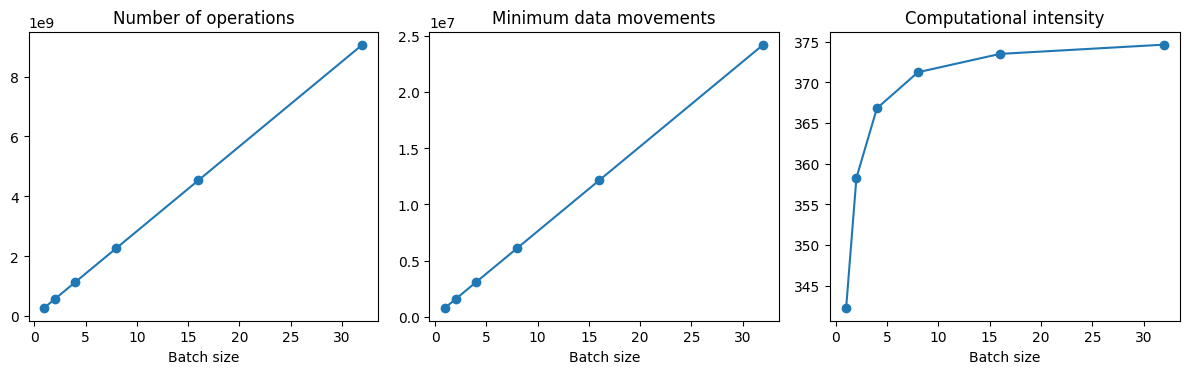

In [19]:
input_shape = {"N": 1, "C": 64, "H": 64, "W": 64}
filter_shape = {"M": 128, "C": 64, "R": 3, "S": 3}

batch_sizes = []
num_ops = []
data_movements = []
computational_intensities = []
for batch_size in [1, 2, 4, 8, 16, 32]:
    input_shape["N"] = batch_size
    batch_sizes.append(batch_size)
    num_ops.append(conv_ops(input_shape, filter_shape))
    data_movements.append(min_conv_data_movement(input_shape, filter_shape))
    computational_intensities.append(conv_computational_intensity(input_shape, filter_shape))

fig, axes = plt.subplots(1, 3, sharex=True, figsize=(12, 4))
axes[0].plot(batch_sizes, num_ops, marker='o')
axes[0].set_xlabel("Batch size")
axes[0].set_title("Number of operations")
axes[1].plot(batch_sizes, data_movements, marker='o')
axes[1].set_xlabel("Batch size")
axes[1].set_title("Minimum data movements")
axes[2].plot(batch_sizes, computational_intensities, marker='o')
axes[2].set_xlabel("Batch size")
axes[2].set_title("Computational intensity")
fig.tight_layout()

Now, please answer the questions below.
Note: X and Y being "proportional" means the ratio of X to Y is constant.

As a hint, it might be helpful to observe the amount of data movement and operations **per input in a batch**.
A code block (not graded) is provided below the questions block for you to modify as you wish and explore some explanations for the trend you observe.

In [20]:
answer(
    "2.3.3",
    "True/False: Computational intensity is always proportional to batch size.",
    required_type=bool,
    answer= False,
)

answer(
    "2.3.4",
    "True/False: Number of operations is always proportional to batch size.",
    required_type=bool,
    answer= True,
)

answer(
    "2.3.5",
    "True/False: Minimum data movement is always proportional to batch size.",
    required_type=bool,
    answer= False,
)

2.3.3: True/False: Computational intensity is always proportional to batch size.
	False
2.3.4: True/False: Number of operations is always proportional to batch size.
	True
2.3.5: True/False: Minimum data movement is always proportional to batch size.
	False


The plotting code block above has been copied below for you to edit as you wish.
This code block is not graded, but will hint you towards the correct answer for the questions above.

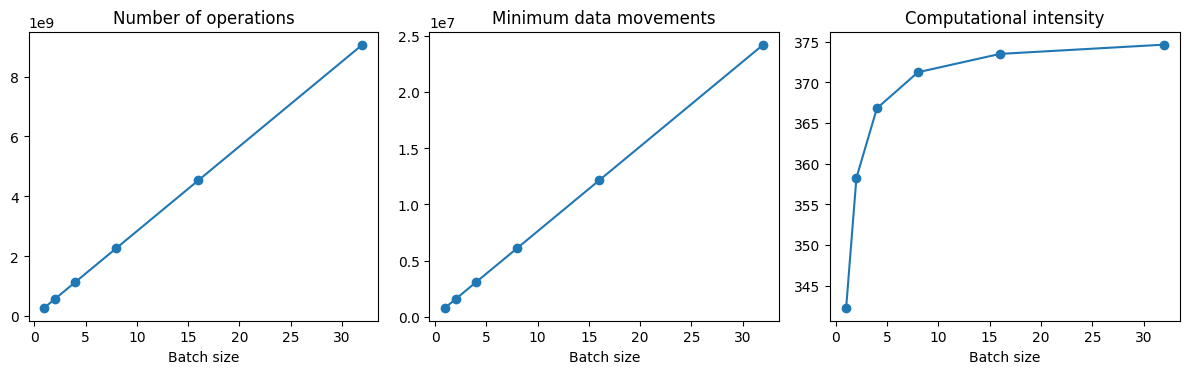

In [21]:
# Edit this cell as you wish
input_shape = {"N": 1, "C": 64, "H": 64, "W": 64}
filter_shape = {"M": 128, "C": 64, "R": 3, "S": 3}

batch_sizes = []
num_ops = []
data_movements = []
computational_intensities = []
for batch_size in [1, 2, 4, 8, 16, 32]:
    input_shape["N"] = batch_size
    batch_sizes.append(batch_size)
    num_ops.append(conv_ops(input_shape, filter_shape))    # <--- modify this line to calculate per batch instead (or any other modifications you wish)
    data_movements.append(min_conv_data_movement(input_shape, filter_shape))   # <--- modify this line to calculate per batch instead (or any other modifications you wish)
    computational_intensities.append(conv_computational_intensity(input_shape, filter_shape))

fig, axes = plt.subplots(1, 3, sharex=True, figsize=(12, 4))
axes[0].plot(batch_sizes, num_ops, marker='o')
axes[0].set_xlabel("Batch size")
axes[0].set_title("Number of operations")
axes[1].plot(batch_sizes, data_movements, marker='o')
axes[1].set_xlabel("Batch size")
axes[1].set_title("Minimum data movements")
axes[2].plot(batch_sizes, computational_intensities, marker='o')
axes[2].set_xlabel("Batch size")
axes[2].set_title("Computational intensity")
fig.tight_layout()

### Question 4: Estimating Computation and Data Movement Latency

We will now estimate latency of computation by dividing the number of operations
with the throughput at which the accelerator can perform operations.

Throughput is often given in two units: operations per second and operations per cycle,
and they are related by the frequency of the accelerator (the cycles per second).

Please answer the questions below.

In [22]:
answer(
    "2.4.1",
    """
    If an accelerator has 1,000 computation units and each computation unit can
    perform 2 operations per cycle, what is the peak computation throughput of
    the accelerator (in operations per cycle)?
    """,
    required_type=Number,
    answer= 2000,
)
answer(
    "2.4.2",
    """
    If there are 12 Tops (12 tera-operations, 12e12 multiplications) to perform
    and an accelerator can perform 60 ops/cycle, how many Gcycles (giga-cycle,
    1e9 cycles) will it require to finish the computation?
    """,
    required_type=Number,
    answer= 200,
)

2.4.1: 
    If an accelerator has 1,000 computation units and each computation unit can
    perform 2 operations per cycle, what is the peak computation throughput of
    the accelerator (in operations per cycle)?
    
	2000
2.4.2: 
    If there are 12 Tops (12 tera-operations, 12e12 multiplications) to perform
    and an accelerator can perform 60 ops/cycle, how many Gcycles (giga-cycle,
    1e9 cycles) will it require to finish the computation?
    
	200


Please implement a function that calculates the computation latency given number of operations and the throughput (in operations per cycle).

In [23]:
def get_computation_latency(num_ops: Number, ops_throughput: Number) -> Number:
    """
    Return latency of computation (in cycles) to process `num_ops` number of
    operations given `ops_throughput` number of operations per cycle.
    """
    return num_ops / ops_throughput
    ########################
    #### YOUR CODE HERE ####
    ########################


answer(
    "2.4.3",
    "Your model for computation latency.",
    required_type=callable,
    answer=get_computation_latency,
)

2.4.3: Your model for computation latency.
	{'callable': 'get_computation_latency', 'source': 'def get_computation_latency(num_ops: Number, ops_throughput: Number) -> Number:\n    """\n    Return latency of computation (in cycles) to process `num_ops` number of\n    operations given `ops_throughput` number of operations per cycle.\n    """\n    return num_ops / ops_throughput\n    ########################\n    #### YOUR CODE HERE ####\n    ########################'}


Let's apply our model! As a case study, consider a filter design approach in CNNs: using multiple
convolutional layers with smaller filter widths and heights to achieve the same accuracy as
fewer layers with larger filters. For example, using two convolutions with 3x3 filters
can achieve better accuracy than one convolution with a 5x5 filter.
By using two convolutions with smaller filters, you change the number of operations that
must be performed.

Please answer the questions below.

In [24]:
# Use the following values for your modeling
input_shape = {"N": 1, "C": 64, "H": 24, "W": 24}

filter_shape_5x5 = {"C": 64, "M": 128, "R": 5, "S": 5}
filter_shape_3x3 = {"C": 64, "M": 128, "R": 3, "S": 3}

throughput = 8e3 # 8 kops/cycle
bandwidth = 25   # 25 ops/cycle

########################
#### YOUR CODE HERE ####
########################

ops_5x5 = conv_ops(input_shape, filter_shape_5x5)
latency_5x5 = get_computation_latency(ops_5x5, throughput)

ops_3x3 = conv_ops(input_shape, filter_shape_3x3)
latency_two_3x3 = 2 * get_computation_latency(ops_3x3, throughput)

# Using the functions above, answer the following questions
answer(
    "2.4.4",
    "What is the computation latency of 5x5 convolution?",
    required_type=Number,
    answer= latency_5x5,
)

answer(
    "2.4.5",
    "What is the latency of two 3x3 convolutions?",
    required_type=Number,
    answer= latency_two_3x3,
)

2.4.4: What is the computation latency of 5x5 convolution?
	10240.0
2.4.5: What is the latency of two 3x3 convolutions?
	8921.088


For this lab, we will define data movement latency as the amount of time taken to
complete data movement. We will estimate this latency by dividing the amount of data
movement with the DRAM bandwidth, which is the amount of data that can be moved per
cycle.

Because we are only considering data movement to/from DRAM, "data movement latency" in
this lab refers to only the latency of data movement to/from DRAM.

Please implement a function to estimate latency of data movement **assuming that the minimum data movement is achieved**.

In [25]:
def data_movement_latency(amount_of_data_movement: Number, bandwidth: Number) -> Number:
    """
    Return latency (in cycles) to move `amount_of_data_movement` (in
    tensor-elements) given `bandwidth` (in tensor-elements/cycle).
    """
    return amount_of_data_movement / bandwidth
    ########################
    #### YOUR CODE HERE ####
    ########################


answer(
    "2.4.6",
    "Your data_movement_latency",
    required_type=callable,
    answer=data_movement_latency,
)

2.4.6: Your data_movement_latency
	{'callable': 'data_movement_latency', 'source': 'def data_movement_latency(amount_of_data_movement: Number, bandwidth: Number) -> Number:\n    """\n    Return latency (in cycles) to move `amount_of_data_movement` (in\n    tensor-elements) given `bandwidth` (in tensor-elements/cycle).\n    """\n    return amount_of_data_movement / bandwidth\n    ########################\n    #### YOUR CODE HERE ####\n    ########################'}


Please answer the question below (you may find it helpful to use the functions you have implemented).

In [26]:
# Assume a convolutional layer with the following shape
input_shape = {"N": 4, "C": 64, "H": 256, "W": 256}

filter_shape = {"C": 64, "M": 64, "R": 3, "S": 3}

throughput = 8e3 # 8 kops/cycle
bandwidth = 25   # 25 ops/cycle


########################
#### YOUR CODE HERE ####
########################

dm = min_conv_data_movement(input_shape, filter_shape)
dm_lat = data_movement_latency(dm, bandwidth)

answer(
    "2.4.7",
    "What is the data movement latency of this layer?",
    required_type=Number,
    answer= dm_lat,
)

2.4.7: What is the data movement latency of this layer?
	1333207.04


### Question 5: Estimating Overall Latency
We will now estimate the overall latency of the DNN processing.

We will explore two choices of assumptions of our ability to **overlap** data movement
and computation.

**Assumption 1: No Overlap of Data Movement and Computation** First, we will assume no
overlap of data movement and computation. That is, all reads must occur before any
computation begins and all writes occur after all computation ends:

**Step 1**: Perform all reads from off-chip memory

**Step 2**: Perform all computation

**Step 3**: Perform all writes to off-chip memory

Please implement a function to calculate the overall latency assuming no overlap of data movement and computation.

In [27]:
def overall_latency_no_overlap(
    data_movement_latency: Number, computation_latency: Number
) -> Number:
    return data_movement_latency + computation_latency
    ########################
    #### YOUR CODE HERE ####
    ########################


answer(
    "2.5.1",
    "Your overall_latency_no_overlap.",
    required_type=callable,
    answer=overall_latency_no_overlap,
)

2.5.1: Your overall_latency_no_overlap.
	{'callable': 'overall_latency_no_overlap', 'source': 'def overall_latency_no_overlap(\n    data_movement_latency: Number, computation_latency: Number\n) -> Number:\n    return data_movement_latency + computation_latency\n    ########################\n    #### YOUR CODE HERE ####\n    ########################'}


**Assumption 2: Maximum Overlap of Data Movement and Computation**

Now, we assume that data movement and computation can be maximally overlapped. In other
words, data movement and computation can occur in parallel.
- If data movement takes longer than computation, then the full compute bandwidth will
simply not be fully utilized. DRAM will be read/written at full speed, and compute units
may need to wait for data to be read/written. Because data movement determines latency
(compute units wait for DRAM to provide needed data), we call this case
**bandwidth-bound**.
- If computation takes longer than data movement, then the full DRAM bandwidth will
simply not be fully utilized. Computation units will proceed at full speed, and memory
will be read/written as needed by the computation. Because computation determines
latency (DRAM waits for compute to finish before reading/writing data), we call this
case **compute-bound**.

Please implement a function to calculate the overall latency assuming maximum overlap of data movement and computation.

In [28]:
def overall_latency_maximum_overlap(
    data_movement_latency: Number,
    computation_latency: Number,
) -> Number:
    return max(data_movement_latency, computation_latency)
    ########################
    #### YOUR CODE HERE ####
    ########################


answer(
    "2.5.2",
    "Your overall_latency_maximum_overlap.",
    required_type=callable,
    answer=overall_latency_maximum_overlap,
)

2.5.2: Your overall_latency_maximum_overlap.
	{'callable': 'overall_latency_maximum_overlap', 'source': 'def overall_latency_maximum_overlap(\n    data_movement_latency: Number,\n    computation_latency: Number,\n) -> Number:\n    return max(data_movement_latency, computation_latency)\n    ########################\n    #### YOUR CODE HERE ####\n    ########################'}


Please answer the following questions.

In [29]:
answer(
    "2.5.3",
    "True/False: For layers with high computational intensity, the processing is more likely to be compute-bound.",
    required_type=bool,
    answer= True,
)

answer(
    "2.5.4",
    "True/False: For layers with low computational intensity, the processing is more likely to be compute-bound.",
    required_type=bool,
    answer= False,
)

2.5.3: True/False: For layers with high computational intensity, the processing is more likely to be compute-bound.
	True


2.5.4: True/False: For layers with low computational intensity, the processing is more likely to be compute-bound.
	False


### Question 6: Visualizing Latency with Maximum Overlap using the Roofline Model
The roofline model is a useful visualization of latency assuming maximum overlap. In
this question, we will explore the roofline model.

In the roofline model, we are interested in knowing the **actual** computation
throughput, which is the number of operations divided by the overall latency while
considering both compute and data movement bottlenecks.

Please answer the following questions.

In [30]:
answer(
    "2.6.1",
    """
    True/False: If the processing is compute-bound, actual computation throughput is
    lower than peak computation throughput.
    """,
    required_type=bool,
    answer= False,
)

answer(
    "2.6.2",
    """
    True/False: If the processing is bandwidth-bound, actual computation throughput is
    lower than peak computation throughput.
    """,
    required_type=bool,
    answer= True,
)

2.6.1: 
    True/False: If the processing is compute-bound, actual computation throughput is
    lower than peak computation throughput.
    
	False


2.6.2: 
    True/False: If the processing is bandwidth-bound, actual computation throughput is
    lower than peak computation throughput.
    
	True


Please implement a function that calculates the actual computation throughput,
defined as the number of operations divided by the overall latency.

In [31]:
def get_actual_computation_throughput(
    num_operations,
    data_movement_latency,
    computation_latency,
):
    return num_operations / overall_latency_maximum_overlap(
        data_movement_latency, computation_latency
    )


answer(
    "2.6.3",
    "Your get_actual_computation_throughput.",
    required_type=callable,
    answer=get_actual_computation_throughput,
)

2.6.3: Your get_actual_computation_throughput.
	{'callable': 'get_actual_computation_throughput', 'source': 'def get_actual_computation_throughput(\n    num_operations,\n    data_movement_latency,\n    computation_latency,\n):\n    return num_operations / overall_latency_maximum_overlap(\n        data_movement_latency, computation_latency\n    )'}


As we identified before, whether the processing of a layer is compute- or
bandwidth-bound is related to the computational intensity of the layer.

Below, please implement a function to calculate the computational intensity at
which the layer processing turns from bandwidth- to compute-bound based on the
computational throughput and bandwidth of the architecture.

In [32]:
def roofline_transition(
    peak_computational_throughput: Number, bandwidth: Number
) -> Number:
    """
    Return the computational intensity (in ops/tensor-element) when the
    processing turns from bandwidth- to compute-bound.

    Parameters
    ----------
    peak_computational_throughput:
        Peak computational throughput in ops/cycle
    bandwidth:
        Memory bandwidth in tensor-element/cycle
    """
    return peak_computational_throughput / bandwidth
    ########################
    #### YOUR CODE HERE ####
    ########################

answer(
    "2.6.4",
    "Your roofline_transition.",
    required_type=callable,
    answer=roofline_transition,
)

2.6.4: Your roofline_transition.
	{'callable': 'roofline_transition', 'source': 'def roofline_transition(\n    peak_computational_throughput: Number, bandwidth: Number\n) -> Number:\n    """\n    Return the computational intensity (in ops/tensor-element) when the\n    processing turns from bandwidth- to compute-bound.\n\n    Parameters\n    ----------\n    peak_computational_throughput:\n        Peak computational throughput in ops/cycle\n    bandwidth:\n        Memory bandwidth in tensor-element/cycle\n    """\n    return peak_computational_throughput / bandwidth\n    ########################\n    #### YOUR CODE HERE ####\n    ########################'}


Please run the cell below, which plots the roofline model and actual throughputs
calculated using your implementations as we vary batch size.

If you implemented these functions correctly, you should see points directly on top of
the lines, implying that the functions you have implemented do indeed calculate the
best-case scenario (represented by the roofline model). This means that all resources
in the hardware (*e.g.*, computation units, memory and network bandwidth) can be fully
utilized.

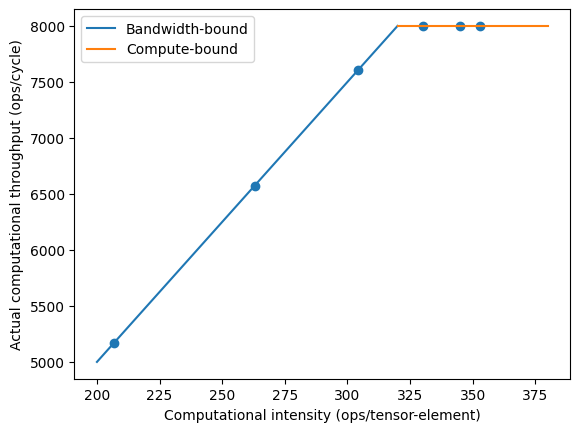

In [33]:
# Assume a convolutional layer with the following shape
input_shape = {"N": 4, "C": 64, "H": 24, "W": 24}

filter_shape = {"C": 64, "M": 128, "R": 3, "S": 3}

throughput = 8e3 # 8 kops/cycle
bandwidth = 25   # 25 ops/cycle

fig, ax = plt.subplots()

MIN_CI = 200
MAX_CI = 380


computational_intensities = []
actual_throughputs = []
for N in [1, 2, 4, 8, 16, 32]:
    input_shape["N"] = N
    num_conv_ops = conv_ops(input_shape, filter_shape)
    data_movement = min_conv_data_movement(input_shape, filter_shape)
    computational_intensity = num_conv_ops / data_movement
    actual_computation_tput = get_actual_computation_throughput(
        num_conv_ops,
        data_movement_latency(data_movement, bandwidth),
        get_computation_latency(num_conv_ops, throughput),
    )
    computational_intensities.append(computational_intensity)
    actual_throughputs.append(actual_computation_tput)
ax.scatter(computational_intensities, actual_throughputs)

ax.plot(
    [MIN_CI, roofline_transition(throughput, bandwidth)],
    [MIN_CI*bandwidth, throughput],
    label="Bandwidth-bound",
)
ax.plot(
    [roofline_transition(throughput, bandwidth), MAX_CI],
    [throughput, throughput],
    label="Compute-bound",
)
ax.set_xlabel("Computational intensity (ops/tensor-element)")
ax.set_ylabel("Actual computational throughput (ops/cycle)")
ax.legend()

Before, we have analyzed the difference in computation latency of convolutions with
5x5 and 3x3 filters. Now that we have a model that accounts for data movement, we
will compare again.

Please run the cell below.

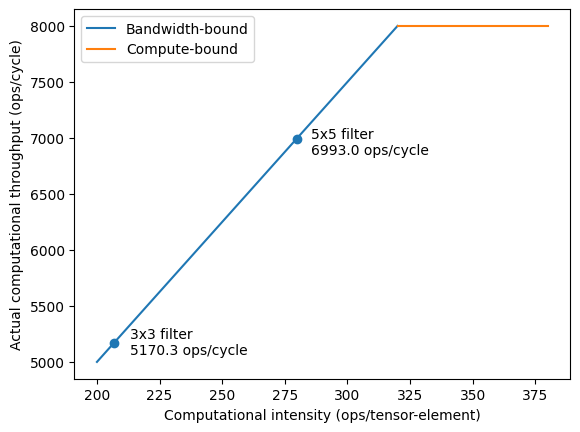

In [34]:
# Use the following values for your modeling
input_shape = {"N": 1, "C": 64, "H": 24, "W": 24}

filter_shape_5x5 = {"C": 64, "M": 128, "R": 5, "S": 5}
filter_shape_3x3 = {"C": 64, "M": 128, "R": 3, "S": 3}

throughput = 8e3 # 8 kops/cycle
bandwidth = 25   # 25 ops/cycle


fig, ax = plt.subplots()

MIN_CI = 200
MAX_CI = 380

computational_intensities = []
actual_throughputs = []
for filter_shape in [filter_shape_3x3, filter_shape_5x5]:
    num_conv_ops = conv_ops(input_shape, filter_shape)
    data_movement = min_conv_data_movement(input_shape, filter_shape)
    computational_intensity = num_conv_ops / data_movement
    actual_computation_tput = get_actual_computation_throughput(
        num_conv_ops,
        data_movement_latency(data_movement, bandwidth),
        get_computation_latency(num_conv_ops, throughput),
    )
    computational_intensities.append(computational_intensity)
    actual_throughputs.append(actual_computation_tput)
ax.scatter(computational_intensities, actual_throughputs)

ax.text(computational_intensities[0]*1.03, actual_throughputs[0]*0.98, f"3x3 filter\n{actual_throughputs[0]:.1f} ops/cycle")
ax.text(computational_intensities[1]*1.02, actual_throughputs[1]*0.98, f"5x5 filter\n{actual_throughputs[1]:.1f} ops/cycle")

ax.plot(
    [MIN_CI, roofline_transition(throughput, bandwidth)],
    [MIN_CI*bandwidth, throughput],
    label="Bandwidth-bound",
)
ax.plot(
    [roofline_transition(throughput, bandwidth), MAX_CI],
    [throughput, throughput],
    label="Compute-bound",
)
ax.set_xlabel("Computational intensity (ops/tensor-element)")
ax.set_ylabel("Actual computational throughput (ops/cycle)")
ax.legend()

Please answer the following questions.

In [35]:
answer(
    "2.6.5",
    """
    Which convolution (answer with '3x3' or '5x5') has lower computational 
    intensity?
    """,
    required_type=("3x3", "5x5"),
    answer= '3x3',
)

########################
#### YOUR CODE HERE ####
########################

# Compute overall latency ratio of 5x5 to two 3x3
input_shape = {"N": 1, "C": 64, "H": 24, "W": 24}
filter_shape_5x5 = {"C": 64, "M": 128, "R": 5, "S": 5}
filter_shape_3x3 = {"C": 64, "M": 128, "R": 3, "S": 3}
throughput = 8e3
bandwidth = 25

ops_5x5 = conv_ops(input_shape, filter_shape_5x5)
dm_5x5 = min_conv_data_movement(input_shape, filter_shape_5x5)
dm_lat_5x5 = data_movement_latency(dm_5x5, bandwidth)
comp_lat_5x5 = get_computation_latency(ops_5x5, throughput)
overall_5x5 = overall_latency_maximum_overlap(dm_lat_5x5, comp_lat_5x5)

ops_3x3 = conv_ops(input_shape, filter_shape_3x3)
dm_3x3 = min_conv_data_movement(input_shape, filter_shape_3x3)
dm_lat_3x3 = data_movement_latency(dm_3x3, bandwidth)
comp_lat_3x3 = get_computation_latency(ops_3x3, throughput)
overall_3x3 = overall_latency_maximum_overlap(dm_lat_3x3, comp_lat_3x3)

ratio = overall_5x5 / (2 * overall_3x3)

answer(
    "2.6.6",
    """
    What is the ratio of the overall latency (maximum overlap) of the 5x5
    convolution to the two 3x3 convolutions?
    Hint: use the actual throughputs you see in the roofline model.
    """,
    required_type=Number,
    answer= ratio,
)

2.6.5: 
    Which convolution (answer with '3x3' or '5x5') has lower computational 
    intensity?
    
	3x3
2.6.6: 
    What is the ratio of the overall latency (maximum overlap) of the 5x5
    convolution to the two 3x3 convolutions?
    Hint: use the actual throughputs you see in the roofline model.
    
	0.8486646884272996


## Section 3: Introduction to Designing and Evaluating Accelerators with AccelForge
As you have seen, modeling latency and energy of an accelerator and workload is important. However, there are nuances that must be considered, many of which are simplified away in this lab.

In the rest of the class, you will use AccelForge to model DNN processing on accelerators.
AccelForge is an accelerator evaluation and design framework developed in the Energy-Efficient Multimedia Systems lab that will take into account those nuances and many optimizations that we will cover in class.

There are many components to AccelForge, and we will start small: In the rest of this lab, we will learn how to specify a DNN as a workload input to AccelForge.

### Question 1: Reading an AccelForge Workload
The workload specification (spec for short) describes the workload being processed.

Please run the cell below and observe the specification of a fully-connected layer.

In [36]:
import accelforge as af
from accelforge.mapper import Metrics


with open("./specs/fc.workload.yaml") as f:
	print(f.read())

workload:
  rank_sizes:
    M: 128
    N: 128
    K: 128

  einsums:
  - name: Fc
    tensor_accesses:
    - name: I
      projection: [m, k]
      bits_per_value: 8
    - name: F
      projection: [k, n]
      bits_per_value: 8
    - name: O
      projection: [m, n]
      output: True
      bits_per_value: 8


Please answer the questions below.

In [37]:
answer(
    "3.1.1",
    "What are the ranks of tensor I?",
    required_type=set[str],
    answer= {'M', 'K'},
)
answer(
    "3.1.2",
    "What are the ranks of tensor O?",
    required_type=set[str],
    answer= {'M', 'N'},
)
answer(
    "3.1.3",
    "What are the rank variables?",
    required_type=set[str],
    answer= {'m', 'n', 'k'},
)
answer(
    "3.1.4",
    "What is the shape of rank M?",
    required_type=Number,
    answer= 128,
)

3.1.1: What are the ranks of tensor I?
	{'M', 'K'}
3.1.2: What are the ranks of tensor O?
	{'M', 'N'}
3.1.3: What are the rank variables?
	{'k', 'm', 'n'}


3.1.4: What is the shape of rank M?
	128


Displaying the spec value in Jupyter notebook renders a graphical representation of the workload.
Rectangles denote Einsums and ovals denote tensors.

For example, please run the cell below.

In [38]:
spec = af.spec.Spec.from_yaml(
	"./specs/fc.workload.yaml"
)
spec.workload

FileNotFoundError: [Errno 2] "dot" not found in path.

Workload(einsums=[Einsum(name='Fc', tensor_accesses=[TensorAccess(name='I', projection={'M': 'm', 'K': 'k'}, output=False, persistent=False, backing_storage_size_scale=1.0, bits_per_value=8), TensorAccess(name='F', projection={'K': 'k', 'N': 'n'}, output=False, persistent=False, backing_storage_size_scale=1.0, bits_per_value=8), TensorAccess(name='O', projection={'M': 'm', 'N': 'n'}, output=True, persistent=False, backing_storage_size_scale=1.0, bits_per_value=8)], iteration_space_shape=[], rank_sizes={}, is_copy_operation=False, renames=[], n_instances=1)], iteration_space_shape={}, rank_sizes={'M': 128, 'N': 128, 'K': 128}, n_instances=1, bits_per_value={}, persistent_tensors=None)

Now, we will inspect a more complicated, convolution workload specification.

Please run the cell below.

In [39]:
with open("./specs/conv.workload.yaml", "r") as f:
    print(f.read())

workload:
  rank_sizes:
    M: 128
    C: 64
    N: {{N}}
    P: 24
    Q: 24
    R: 3
    S: 3

  einsums:
  - name: Conv
    tensor_accesses:
    - name: I
      projection: {N: n, C: c, H: p+r, W: q+s}
      bits_per_value: 8  # bits per tensor element
    - name: F
      projection: [m, c, r, s]
      bits_per_value: 8
    - name: O
      projection: [n, m, p, q]
      bits_per_value: 8
      output: True


The notation `{{N}}` in the spec above allows us to customize values as we parse the YAML into Python.
In particular, the expression `{{N}}` will be substituted with a value in Python code.
You will see this feature used later in this section.

Please answer the following question.

In [40]:
answer(
    "3.1.5",
    "True/False: A numerical value is provided for the shape of rank N in the spec above.",
    required_type=bool,
    answer= False,
)

3.1.5: True/False: A numerical value is provided for the shape of rank N in the spec above.
	False


As before, we can visualize the workload. Please run the cell below.

In [41]:
spec = af.Spec.from_yaml(
    "./specs/conv.workload.yaml",
    jinja_parse_data={"N": 1}
)
spec.workload

FileNotFoundError: [Errno 2] "dot" not found in path.

Workload(einsums=[Einsum(name='Conv', tensor_accesses=[TensorAccess(name='I', projection={'N': 'n', 'C': 'c', 'H': 'p+r', 'W': 'q+s'}, output=False, persistent=False, backing_storage_size_scale=1.0, bits_per_value=8), TensorAccess(name='F', projection={'M': 'm', 'C': 'c', 'R': 'r', 'S': 's'}, output=False, persistent=False, backing_storage_size_scale=1.0, bits_per_value=8), TensorAccess(name='O', projection={'N': 'n', 'M': 'm', 'P': 'p', 'Q': 'q'}, output=True, persistent=False, backing_storage_size_scale=1.0, bits_per_value=8)], iteration_space_shape=[], rank_sizes={}, is_copy_operation=False, renames=[], n_instances=1)], iteration_space_shape={}, rank_sizes={'M': 128, 'C': 64, 'N': 1, 'P': 24, 'Q': 24, 'R': 3, 'S': 3}, n_instances=1, bits_per_value={}, persistent_tensors=None)

Please answer the following questions.

In [42]:
answer(
    "3.1.6",
    "What are the ranks of tensor I?",
    required_type=set[str],
    answer= {'N', 'C', 'H', 'W'},
)
answer(
    "3.1.7",
    "What are the ranks of tensor O?",
    required_type=set[str],
    answer= {'N', 'M', 'P', 'Q'},
)
answer(
    "3.1.8",
    "What are the rank variables in the index expression into rank H in tensor I?",
    required_type=set[str],
    answer= {'p', 'r'},
)
answer(
    "3.1.9",
    "What is the shape of rank M?",
    required_type=Number,
    answer= 128,
)

3.1.6: What are the ranks of tensor I?
	{'C', 'H', 'N', 'W'}
3.1.7: What are the ranks of tensor O?
	{'M', 'Q', 'N', 'P'}


3.1.8: What are the rank variables in the index expression into rank H in tensor I?
	{'r', 'p'}
3.1.9: What is the shape of rank M?
	128


### Question 2: Reading an AccelForge Architecture
Now, we will read an AccelForge architecture specification. **Assume that the chip runs at 1 GHz frequency.**

First, please run the code block below to print out the specs.

In [43]:
with open("./specs/simple.arch.yaml") as f:
	print(f.read())

arch:
  nodes:
  - !Memory
    name: DRAM
    component_class: LPDDR4
    size: inf
    total_latency: (read_actions + write_actions)/(200e9)  # equivalent to 200 Gb/s bandwidth
    tensors:
      keep: All
    extra_attributes_for_component_model:
      width: 64

  - !Memory
    name: OnchipBuffer
    size: 1024*1024 # size in bits
    total_latency: (read_actions + write_actions)/64e12  # equivalent to 64 Tb/s bandwidth
    area: 0  # we are not modeling area
    leak_power: 0 # we are not modeling leakage
    tensors:
      keep: All
    actions:
    - name: read
      energy: 5
      latency: 0
    - name: write
      energy: 5
      latency: 0

  - !Compute
    name: MAC
    area: 0  # we are not modeling area
    leak_power: 0 # we are not modeling leakage
    spatial:
    - name: ComputeArrayX
      fanout: 32
      loop_bounds:
      - expression: c
        operator: ==
        value: 32
      - expression: m
        operator: ==
        value: 1
      - expression: p
        

Now, please answer the following questions.

In [44]:
answer(
    '3.2.1',
    "What are the two memory levels of the architecture?",
    required_type=set[str],
    answer= {'DRAM', 'OnchipBuffer'},
)

answer(
    "3.2.2",
    "What is the size of the OnchipBuffer (in number of tensor-elements)?",
    required_type=Number,
    answer= 131072,
)

answer(
    "3.2.3",
    "What is the bandwidth of the DRAM (in tensor-element/cycle)?",
    required_type=Number,
    answer= 25,
)

answer(
    '3.2.4',
    "What is the name of the compute unit?",
    required_type=str,
    answer= 'MAC',
)

3.2.1: What are the two memory levels of the architecture?
	{'OnchipBuffer', 'DRAM'}
3.2.2: What is the size of the OnchipBuffer (in number of tensor-elements)?
	131072


3.2.3: What is the bandwidth of the DRAM (in tensor-element/cycle)?
	25


3.2.4: What is the name of the compute unit?
	MAC


### Question 3: Modeling Accelerator Latency and Energy using AccelForge.
Now, we put the workload and architecture together as input to the *mapper*, which will optimize how operations and data movement are scheduled onto the accelerator.

As we did before, we vary batch size and plot actual throughput (now estimated using accelforge) against computational intensity. We will draw the roofline model as well for comparison.

Please run the cell below to generate data points using accelforge and plot those points against the roofline model.

Getting energy, latency, and leak power for components running :   0%|          | 0/1 [00:00<?, ?it/s]

Getting energy, latency, and leak power for components running Conv:   0%|          | 0/1 [00:00<?, ?it/s]

Getting energy, latency, and leak power for components running Conv: 100%|██████████| 1/1 [00:00<00:00, 26.97it/s]

Generating jobs:   0%|          | 0/1 [00:00<?, ?it/s]

Generating pmapping templates for compute MAC Einsum Conv: 0it [00:00, ?it/s]

Generating pmapping templates for compute MAC Einsum Conv: 24it [00:00, 329.77it/s]


Generating jobs: 100%|██████████| 1/1 [00:00<00:00,  8.36it/s]

Generating jobs: 100%|██████████| 1/1 [00:00<00:00,  8.31it/s]

Einsum Conv has 24 pmapping templates:
	0	[O in DRAM] [I in DRAM] [F in DRAM] T-c  T-m  T-p  T-q  T-r  T-s  [F in OnchipBuffer] T-n  T-p  T-q  [I in OnchipBuffer] T-s  T-p  T-q  T-r  T-m  [O in OnchipBuffer] T-c  T-r  T-s  S-ComputeArrayY-n  S-ComputeArrayY-m  S-ComputeArrayX-c  MAC computes Conv
	1	[O in DRAM] [I in DRAM] [F in DRAM] T-c  T-m  T-p  T-q  T-r  T-s  [F in OnchipBuffer] T-n  T-p  T-q  [I in OnchipBuffer] T-r  T-p  T-q  T-s  T-m  [O in OnchipBuffer] T-c  T-r  T-s  S-ComputeArrayY-n  S-ComputeArrayY-m  S-ComputeArrayX-c  MAC computes Conv
	2	[O in DRAM] [I in DRAM] [F in DRAM] T-c  T-m  T-p  T-q  T-r  T-s  [F in OnchipBuffer] T-n  T-p  T-q  [I in OnchipBuffer] T-q  T-p  T-r  T-s  T-m  [O in OnchipBuffer] T-c  T-r  T-s  S-ComputeArrayY-n  S-ComputeArrayY-m  S-ComputeArrayX-c  MAC computes Conv
	3	[O in DRAM] [I in DRAM] [F in DRAM] T-c  T-m  T-p  T-q  T-r  T-s  [F in OnchipBuffer] T-n  T-p  T-q  [I in OnchipBuffer] T-p  T-q  T-r  T-s  T-m  [O in OnchipBuffer] T-c  T-r  T-s  

Generating pmappings:   0%|          | 0/24 [00:00<?, ?it/s]

Generating pmappings:   4%|▍         | 1/24 [00:09<03:34,  9.33s/it]

Generating pmappings:   8%|▊         | 2/24 [00:10<01:37,  4.43s/it]

Generating pmappings:  12%|█▎        | 3/24 [00:10<00:53,  2.53s/it]

Generating pmappings:  17%|█▋        | 4/24 [00:11<00:35,  1.80s/it]

Generating pmappings:  21%|██        | 5/24 [00:11<00:24,  1.30s/it]

Generating pmappings:  25%|██▌       | 6/24 [00:11<00:16,  1.11it/s]

Generating pmappings:  29%|██▉       | 7/24 [00:12<00:13,  1.23it/s]

Generating pmappings:  33%|███▎      | 8/24 [00:12<00:10,  1.50it/s]

Generating pmappings:  42%|████▏     | 10/24 [00:13<00:06,  2.05it/s]

Generating pmappings:  46%|████▌     | 11/24 [00:13<00:05,  2.46it/s]

Generating pmappings:  50%|█████     | 12/24 [00:13<00:04,  2.77it/s]

Generating pmappings:  54%|█████▍    | 13/24 [00:13<00:03,  3.31it/s]

Generating pmappings:  62%|██████▎   | 15/24 [00:14<00:01,  4.81it/s]

Generating pmappings:  67%|██████▋   | 16/24 [00:14<00:01,  4.95it/s]

Generating pmappings:  71%|███████   | 17/24 [00:14<00:01,  5.34it/s]

Generating pmappings:  75%|███████▌  | 18/24 [00:14<00:01,  5.79it/s]

Generating pmappings:  79%|███████▉  | 19/24 [00:14<00:00,  5.97it/s]

Generating pmappings:  83%|████████▎ | 20/24 [00:14<00:00,  6.29it/s]

Generating pmappings:  88%|████████▊ | 21/24 [00:15<00:00,  6.13it/s]

Generating pmappings:  92%|█████████▏| 22/24 [00:15<00:00,  6.12it/s]

Generating pmappings: 100%|██████████| 24/24 [00:15<00:00,  4.27it/s]

Generating pmappings: 100%|██████████| 24/24 [00:15<00:00,  1.51it/s]

Grouping pmappings for Conv:   0%|          | 0/1 [00:00<?, ?it/s]

Grouping pmappings for Conv: 100%|██████████| 1/1 [00:03<00:00,  3.74s/it]

Grouping pmappings for Conv: 100%|██████████| 1/1 [00:03<00:00,  3.74s/it]

Conv: 9.62e07 total, 5.12e07 (1/2) valid, 3.31e05 (1/291) evaluated, 1 (1/9.62e07) Pareto-Optimal
Total: 9.62e07 total, 5.12e07 (1/2) valid, 3.31e05 (1/291) evaluated, 1 (1/9.62e07) Pareto-Optimal


Compressing pmappings:   0%|          | 0/1 [00:00<?, ?it/s]

Compressing pmappings: 100%|██████████| 1/1 [00:00<00:00, 203.05it/s]

Final consolidate:   0%|          | 0/1 [00:00<?, ?it/s]

Final consolidate: 100%|██████████| 1/1 [00:00<00:00, 3052.62it/s]

Getting energy, latency, and leak power for components running :   0%|          | 0/1 [00:00<?, ?it/s]

Getting energy, latency, and leak power for components running Conv:   0%|          | 0/1 [00:00<?, ?it/s]

Getting energy, latency, and leak power for components running Conv: 100%|██████████| 1/1 [00:00<00:00, 36.63it/s]

Generating jobs:   0%|          | 0/1 [00:00<?, ?it/s]

Generating pmapping templates for compute MAC Einsum Conv: 0it [00:00, ?it/s]

Generating pmapping templates for compute MAC Einsum Conv: 24it [00:00, 349.94it/s]


Generating jobs: 100%|██████████| 1/1 [00:00<00:00, 10.25it/s]

Einsum Conv has 24 pmapping templates:
	0	[O in DRAM] [I in DRAM] [F in DRAM] T-c  T-m  T-p  T-q  T-r  T-s  [F in OnchipBuffer] T-n  T-p  T-q  [I in OnchipBuffer] T-s  T-p  T-q  T-r  T-m  [O in OnchipBuffer] T-c  T-r  T-s  S-ComputeArrayY-n  S-ComputeArrayY-m  S-ComputeArrayX-c  MAC computes Conv
	1	[O in DRAM] [I in DRAM] [F in DRAM] T-c  T-m  T-p  T-q  T-r  T-s  [F in OnchipBuffer] T-n  T-p  T-q  [I in OnchipBuffer] T-r  T-p  T-q  T-s  T-m  [O in OnchipBuffer] T-c  T-r  T-s  S-ComputeArrayY-n  S-ComputeArrayY-m  S-ComputeArrayX-c  MAC computes Conv
	2	[O in DRAM] [I in DRAM] [F in DRAM] T-c  T-m  T-p  T-q  T-r  T-s  [F in OnchipBuffer] T-n  T-p  T-q  [I in OnchipBuffer] T-q  T-p  T-r  T-s  T-m  [O in OnchipBuffer] T-c  T-r  T-s  S-ComputeArrayY-n  S-ComputeArrayY-m  S-ComputeArrayX-c  MAC computes Conv
	3	[O in DRAM] [I in DRAM] [F in DRAM] T-c  T-m  T-p  T-q  T-r  T-s  [F in OnchipBuffer] T-n  T-p  T-q  [I in OnchipBuffer] T-p  T-q  T-r  T-s  T-m  [O in OnchipBuffer] T-c  T-r  T-s  

Generating pmappings:   0%|          | 0/24 [00:00<?, ?it/s]

Generating pmappings:   4%|▍         | 1/24 [00:02<01:00,  2.61s/it]

Generating pmappings:   8%|▊         | 2/24 [00:02<00:25,  1.15s/it]

Generating pmappings:  12%|█▎        | 3/24 [00:02<00:15,  1.38it/s]

Generating pmappings:  17%|█▋        | 4/24 [00:03<00:12,  1.62it/s]

Generating pmappings:  21%|██        | 5/24 [00:03<00:08,  2.29it/s]

Generating pmappings:  33%|███▎      | 8/24 [00:04<00:05,  3.11it/s]

Generating pmappings:  42%|████▏     | 10/24 [00:04<00:03,  4.40it/s]

Generating pmappings:  46%|████▌     | 11/24 [00:04<00:03,  3.38it/s]

Generating pmappings:  50%|█████     | 12/24 [00:05<00:03,  3.72it/s]

Generating pmappings:  54%|█████▍    | 13/24 [00:05<00:03,  2.87it/s]

Generating pmappings:  62%|██████▎   | 15/24 [00:05<00:02,  4.29it/s]

Generating pmappings:  67%|██████▋   | 16/24 [00:06<00:01,  4.11it/s]

Generating pmappings:  71%|███████   | 17/24 [00:06<00:02,  3.44it/s]

Generating pmappings:  75%|███████▌  | 18/24 [00:06<00:01,  4.00it/s]

Generating pmappings:  79%|███████▉  | 19/24 [00:06<00:01,  4.58it/s]

Generating pmappings:  83%|████████▎ | 20/24 [00:07<00:01,  2.72it/s]

Generating pmappings:  88%|████████▊ | 21/24 [00:08<00:01,  2.54it/s]

Generating pmappings:  92%|█████████▏| 22/24 [00:08<00:00,  2.80it/s]

Generating pmappings:  96%|█████████▌| 23/24 [00:08<00:00,  2.81it/s]

Generating pmappings: 100%|██████████| 24/24 [00:10<00:00,  1.35it/s]

Generating pmappings: 100%|██████████| 24/24 [00:10<00:00,  2.32it/s]

Grouping pmappings for Conv:   0%|          | 0/1 [00:00<?, ?it/s]

Grouping pmappings for Conv: 100%|██████████| 1/1 [00:00<00:00, 42.66it/s]

Conv: 2.23e08 total, 1.33e08 (1/2) valid, 5.28e05 (1/423) evaluated, 1 (1/2.23e08) Pareto-Optimal
Total: 2.23e08 total, 1.33e08 (1/2) valid, 5.28e05 (1/423) evaluated, 1 (1/2.23e08) Pareto-Optimal


Compressing pmappings:   0%|          | 0/1 [00:00<?, ?it/s]

Compressing pmappings: 100%|██████████| 1/1 [00:00<00:00, 221.35it/s]

Final consolidate:   0%|          | 0/1 [00:00<?, ?it/s]

Final consolidate: 100%|██████████| 1/1 [00:00<00:00, 10255.02it/s]

Getting energy, latency, and leak power for components running :   0%|          | 0/1 [00:00<?, ?it/s]

Getting energy, latency, and leak power for components running Conv:   0%|          | 0/1 [00:00<?, ?it/s]

Getting energy, latency, and leak power for components running Conv: 100%|██████████| 1/1 [00:00<00:00, 50.90it/s]

Generating jobs:   0%|          | 0/1 [00:00<?, ?it/s]

Generating pmapping templates for compute MAC Einsum Conv: 0it [00:00, ?it/s]

Generating pmapping templates for compute MAC Einsum Conv: 24it [00:00, 358.19it/s]


Generating jobs: 100%|██████████| 1/1 [00:00<00:00, 10.85it/s]

Einsum Conv has 24 pmapping templates:
	0	[O in DRAM] [I in DRAM] [F in DRAM] T-c  T-m  T-p  T-q  T-r  T-s  [F in OnchipBuffer] T-n  T-p  T-q  [I in OnchipBuffer] T-s  T-p  T-q  T-r  T-m  [O in OnchipBuffer] T-c  T-r  T-s  S-ComputeArrayY-n  S-ComputeArrayY-m  S-ComputeArrayX-c  MAC computes Conv
	1	[O in DRAM] [I in DRAM] [F in DRAM] T-c  T-m  T-p  T-q  T-r  T-s  [F in OnchipBuffer] T-n  T-p  T-q  [I in OnchipBuffer] T-r  T-p  T-q  T-s  T-m  [O in OnchipBuffer] T-c  T-r  T-s  S-ComputeArrayY-n  S-ComputeArrayY-m  S-ComputeArrayX-c  MAC computes Conv
	2	[O in DRAM] [I in DRAM] [F in DRAM] T-c  T-m  T-p  T-q  T-r  T-s  [F in OnchipBuffer] T-n  T-p  T-q  [I in OnchipBuffer] T-q  T-p  T-r  T-s  T-m  [O in OnchipBuffer] T-c  T-r  T-s  S-ComputeArrayY-n  S-ComputeArrayY-m  S-ComputeArrayX-c  MAC computes Conv
	3	[O in DRAM] [I in DRAM] [F in DRAM] T-c  T-m  T-p  T-q  T-r  T-s  [F in OnchipBuffer] T-n  T-p  T-q  [I in OnchipBuffer] T-p  T-q  T-r  T-s  T-m  [O in OnchipBuffer] T-c  T-r  T-s  

Generating pmappings:   0%|          | 0/24 [00:00<?, ?it/s]

Generating pmappings:   4%|▍         | 1/24 [00:02<00:50,  2.20s/it]

Generating pmappings:   8%|▊         | 2/24 [00:03<00:32,  1.47s/it]

Generating pmappings:  12%|█▎        | 3/24 [00:03<00:18,  1.15it/s]

Generating pmappings:  17%|█▋        | 4/24 [00:03<00:11,  1.76it/s]

Generating pmappings:  21%|██        | 5/24 [00:03<00:09,  2.08it/s]

Generating pmappings:  25%|██▌       | 6/24 [00:04<00:07,  2.30it/s]

Generating pmappings:  42%|████▏     | 10/24 [00:04<00:02,  6.00it/s]

Generating pmappings:  54%|█████▍    | 13/24 [00:04<00:01,  7.13it/s]

Generating pmappings:  62%|██████▎   | 15/24 [00:05<00:01,  4.74it/s]

Generating pmappings:  67%|██████▋   | 16/24 [00:05<00:01,  4.85it/s]

Generating pmappings:  71%|███████   | 17/24 [00:05<00:01,  5.11it/s]

Generating pmappings:  75%|███████▌  | 18/24 [00:05<00:01,  4.40it/s]

Generating pmappings:  83%|████████▎ | 20/24 [00:06<00:00,  6.17it/s]

Generating pmappings:  88%|████████▊ | 21/24 [00:06<00:00,  4.71it/s]

Generating pmappings:  92%|█████████▏| 22/24 [00:06<00:00,  3.80it/s]

Generating pmappings:  96%|█████████▌| 23/24 [00:07<00:00,  3.99it/s]

Generating pmappings: 100%|██████████| 24/24 [00:08<00:00,  1.65it/s]

Generating pmappings: 100%|██████████| 24/24 [00:08<00:00,  2.75it/s]

Grouping pmappings for Conv:   0%|          | 0/1 [00:00<?, ?it/s]

Grouping pmappings for Conv: 100%|██████████| 1/1 [00:00<00:00,  2.62it/s]

Grouping pmappings for Conv: 100%|██████████| 1/1 [00:00<00:00,  2.61it/s]

Conv: 3.81e08 total, 2.39e08 (1/2) valid, 6.15e05 (1/620) evaluated, 1 (1/3.81e08) Pareto-Optimal
Total: 3.81e08 total, 2.39e08 (1/2) valid, 6.15e05 (1/620) evaluated, 1 (1/3.81e08) Pareto-Optimal


Compressing pmappings:   0%|          | 0/1 [00:00<?, ?it/s]

Compressing pmappings: 100%|██████████| 1/1 [00:00<00:00, 143.28it/s]

Final consolidate:   0%|          | 0/1 [00:00<?, ?it/s]

Final consolidate: 100%|██████████| 1/1 [00:00<00:00, 5825.42it/s]

Getting energy, latency, and leak power for components running :   0%|          | 0/1 [00:00<?, ?it/s]

Getting energy, latency, and leak power for components running Conv:   0%|          | 0/1 [00:00<?, ?it/s]

Getting energy, latency, and leak power for components running Conv: 100%|██████████| 1/1 [00:00<00:00, 28.42it/s]

Generating jobs:   0%|          | 0/1 [00:00<?, ?it/s]

Generating pmapping templates for compute MAC Einsum Conv: 0it [00:00, ?it/s]

Generating pmapping templates for compute MAC Einsum Conv: 23it [00:00, 225.80it/s]

Generating pmapping templates for compute MAC Einsum Conv: 24it [00:00, 222.16it/s]


Generating jobs: 100%|██████████| 1/1 [00:00<00:00,  6.74it/s]

Generating jobs: 100%|██████████| 1/1 [00:00<00:00,  6.70it/s]

Einsum Conv has 24 pmapping templates:
	0	[O in DRAM] [I in DRAM] [F in DRAM] T-c  T-m  T-p  T-q  T-r  T-s  [F in OnchipBuffer] T-n  T-p  T-q  [I in OnchipBuffer] T-s  T-p  T-q  T-r  T-m  [O in OnchipBuffer] T-c  T-r  T-s  S-ComputeArrayY-n  S-ComputeArrayY-m  S-ComputeArrayX-c  MAC computes Conv
	1	[O in DRAM] [I in DRAM] [F in DRAM] T-c  T-m  T-p  T-q  T-r  T-s  [F in OnchipBuffer] T-n  T-p  T-q  [I in OnchipBuffer] T-r  T-p  T-q  T-s  T-m  [O in OnchipBuffer] T-c  T-r  T-s  S-ComputeArrayY-n  S-ComputeArrayY-m  S-ComputeArrayX-c  MAC computes Conv
	2	[O in DRAM] [I in DRAM] [F in DRAM] T-c  T-m  T-p  T-q  T-r  T-s  [F in OnchipBuffer] T-n  T-p  T-q  [I in OnchipBuffer] T-q  T-p  T-r  T-s  T-m  [O in OnchipBuffer] T-c  T-r  T-s  S-ComputeArrayY-n  S-ComputeArrayY-m  S-ComputeArrayX-c  MAC computes Conv
	3	[O in DRAM] [I in DRAM] [F in DRAM] T-c  T-m  T-p  T-q  T-r  T-s  [F in OnchipBuffer] T-n  T-p  T-q  [I in OnchipBuffer] T-p  T-q  T-r  T-s  T-m  [O in OnchipBuffer] T-c  T-r  T-s  

Generating pmappings:   0%|          | 0/24 [00:00<?, ?it/s]

Generating pmappings:   4%|▍         | 1/24 [00:02<00:49,  2.16s/it]

Generating pmappings:   8%|▊         | 2/24 [00:02<00:25,  1.16s/it]

Generating pmappings:  12%|█▎        | 3/24 [00:02<00:16,  1.30it/s]

Generating pmappings:  21%|██        | 5/24 [00:03<00:09,  2.03it/s]

Generating pmappings:  29%|██▉       | 7/24 [00:03<00:05,  3.11it/s]

Generating pmappings:  38%|███▊      | 9/24 [00:03<00:03,  4.58it/s]

Generating pmappings:  42%|████▏     | 10/24 [00:04<00:03,  4.29it/s]

Generating pmappings:  46%|████▌     | 11/24 [00:04<00:03,  3.42it/s]

Generating pmappings:  54%|█████▍    | 13/24 [00:04<00:02,  4.45it/s]

Generating pmappings:  62%|██████▎   | 15/24 [00:05<00:02,  4.25it/s]

Generating pmappings:  67%|██████▋   | 16/24 [00:05<00:01,  4.33it/s]

Generating pmappings:  75%|███████▌  | 18/24 [00:05<00:01,  4.54it/s]

Generating pmappings:  79%|███████▉  | 19/24 [00:06<00:01,  4.61it/s]

Generating pmappings:  83%|████████▎ | 20/24 [00:06<00:00,  5.05it/s]

Generating pmappings:  88%|████████▊ | 21/24 [00:06<00:00,  4.48it/s]

Generating pmappings:  96%|█████████▌| 23/24 [00:07<00:00,  3.92it/s]

Generating pmappings: 100%|██████████| 24/24 [00:07<00:00,  4.36it/s]

Generating pmappings: 100%|██████████| 24/24 [00:07<00:00,  3.27it/s]

Grouping pmappings for Conv:   0%|          | 0/1 [00:00<?, ?it/s]

Grouping pmappings for Conv: 100%|██████████| 1/1 [00:00<00:00, 35.16it/s]

Conv: 5.70e08 total, 3.48e08 (1/2) valid, 7.31e05 (1/779) evaluated, 1 (1/5.70e08) Pareto-Optimal
Total: 5.70e08 total, 3.48e08 (1/2) valid, 7.31e05 (1/779) evaluated, 1 (1/5.70e08) Pareto-Optimal


Compressing pmappings:   0%|          | 0/1 [00:00<?, ?it/s]

Compressing pmappings: 100%|██████████| 1/1 [00:00<00:00, 224.40it/s]

Final consolidate:   0%|          | 0/1 [00:00<?, ?it/s]

Final consolidate: 100%|██████████| 1/1 [00:00<00:00, 11848.32it/s]

Getting energy, latency, and leak power for components running :   0%|          | 0/1 [00:00<?, ?it/s]

Getting energy, latency, and leak power for components running Conv:   0%|          | 0/1 [00:00<?, ?it/s]

Getting energy, latency, and leak power for components running Conv: 100%|██████████| 1/1 [00:00<00:00, 35.02it/s]

Generating jobs:   0%|          | 0/1 [00:00<?, ?it/s]

Generating pmapping templates for compute MAC Einsum Conv: 0it [00:00, ?it/s]

Generating pmapping templates for compute MAC Einsum Conv: 21it [00:00, 202.68it/s]

Generating pmapping templates for compute MAC Einsum Conv: 24it [00:00, 203.77it/s]


Generating jobs: 100%|██████████| 1/1 [00:00<00:00,  5.58it/s]

Generating jobs: 100%|██████████| 1/1 [00:00<00:00,  5.49it/s]

Einsum Conv has 24 pmapping templates:
	0	[O in DRAM] [I in DRAM] [F in DRAM] T-c  T-m  T-p  T-q  T-r  T-s  [F in OnchipBuffer] T-n  T-p  T-q  [I in OnchipBuffer] T-s  T-p  T-q  T-r  T-m  [O in OnchipBuffer] T-c  T-r  T-s  S-ComputeArrayY-n  S-ComputeArrayY-m  S-ComputeArrayX-c  MAC computes Conv
	1	[O in DRAM] [I in DRAM] [F in DRAM] T-c  T-m  T-p  T-q  T-r  T-s  [F in OnchipBuffer] T-n  T-p  T-q  [I in OnchipBuffer] T-r  T-p  T-q  T-s  T-m  [O in OnchipBuffer] T-c  T-r  T-s  S-ComputeArrayY-n  S-ComputeArrayY-m  S-ComputeArrayX-c  MAC computes Conv
	2	[O in DRAM] [I in DRAM] [F in DRAM] T-c  T-m  T-p  T-q  T-r  T-s  [F in OnchipBuffer] T-n  T-p  T-q  [I in OnchipBuffer] T-q  T-p  T-r  T-s  T-m  [O in OnchipBuffer] T-c  T-r  T-s  S-ComputeArrayY-n  S-ComputeArrayY-m  S-ComputeArrayX-c  MAC computes Conv
	3	[O in DRAM] [I in DRAM] [F in DRAM] T-c  T-m  T-p  T-q  T-r  T-s  [F in OnchipBuffer] T-n  T-p  T-q  [I in OnchipBuffer] T-p  T-q  T-r  T-s  T-m  [O in OnchipBuffer] T-c  T-r  T-s  

Generating pmappings:   0%|          | 0/24 [00:00<?, ?it/s]

Generating pmappings:   4%|▍         | 1/24 [00:02<00:53,  2.35s/it]

Generating pmappings:  12%|█▎        | 3/24 [00:03<00:21,  1.01s/it]

Generating pmappings:  17%|█▋        | 4/24 [00:03<00:15,  1.32it/s]

Generating pmappings:  21%|██        | 5/24 [00:03<00:10,  1.79it/s]

Generating pmappings:  25%|██▌       | 6/24 [00:04<00:07,  2.36it/s]

Generating pmappings:  33%|███▎      | 8/24 [00:04<00:04,  3.50it/s]

Generating pmappings:  42%|████▏     | 10/24 [00:04<00:02,  5.16it/s]

Generating pmappings:  54%|█████▍    | 13/24 [00:05<00:02,  4.38it/s]

Generating pmappings:  58%|█████▊    | 14/24 [00:05<00:02,  4.53it/s]

Generating pmappings:  62%|██████▎   | 15/24 [00:05<00:02,  3.92it/s]

Generating pmappings:  67%|██████▋   | 16/24 [00:06<00:02,  3.25it/s]

Generating pmappings:  75%|███████▌  | 18/24 [00:06<00:01,  4.25it/s]

Generating pmappings:  79%|███████▉  | 19/24 [00:06<00:01,  4.68it/s]

Generating pmappings:  88%|████████▊ | 21/24 [00:07<00:00,  4.52it/s]

Generating pmappings:  92%|█████████▏| 22/24 [00:07<00:00,  3.18it/s]

Generating pmappings:  96%|█████████▌| 23/24 [00:07<00:00,  3.78it/s]

Generating pmappings: 100%|██████████| 24/24 [00:10<00:00,  1.08it/s]

Generating pmappings: 100%|██████████| 24/24 [00:10<00:00,  2.23it/s]

Grouping pmappings for Conv:   0%|          | 0/1 [00:00<?, ?it/s]

Grouping pmappings for Conv: 100%|██████████| 1/1 [00:00<00:00, 40.20it/s]

Conv: 7.89e08 total, 4.25e08 (1/2) valid, 9.25e05 (1/853) evaluated, 1 (1/7.89e08) Pareto-Optimal
Total: 7.89e08 total, 4.25e08 (1/2) valid, 9.25e05 (1/853) evaluated, 1 (1/7.89e08) Pareto-Optimal


Compressing pmappings:   0%|          | 0/1 [00:00<?, ?it/s]

Compressing pmappings: 100%|██████████| 1/1 [00:00<00:00, 269.87it/s]

Final consolidate:   0%|          | 0/1 [00:00<?, ?it/s]

Final consolidate: 100%|██████████| 1/1 [00:00<00:00, 5475.59it/s]

Getting energy, latency, and leak power for components running :   0%|          | 0/1 [00:00<?, ?it/s]

Getting energy, latency, and leak power for components running Conv:   0%|          | 0/1 [00:00<?, ?it/s]

Getting energy, latency, and leak power for components running Conv: 100%|██████████| 1/1 [00:00<00:00, 33.97it/s]

Generating jobs:   0%|          | 0/1 [00:00<?, ?it/s]

Generating pmapping templates for compute MAC Einsum Conv: 0it [00:00, ?it/s]

Generating pmapping templates for compute MAC Einsum Conv: 23it [00:00, 224.97it/s]

Generating pmapping templates for compute MAC Einsum Conv: 24it [00:00, 218.75it/s]


Generating jobs: 100%|██████████| 1/1 [00:00<00:00,  6.22it/s]

Generating jobs: 100%|██████████| 1/1 [00:00<00:00,  6.19it/s]

Einsum Conv has 24 pmapping templates:
	0	[O in DRAM] [I in DRAM] [F in DRAM] T-c  T-m  T-p  T-q  T-r  T-s  [F in OnchipBuffer] T-n  T-p  T-q  [I in OnchipBuffer] T-s  T-p  T-q  T-r  T-m  [O in OnchipBuffer] T-c  T-r  T-s  S-ComputeArrayY-n  S-ComputeArrayY-m  S-ComputeArrayX-c  MAC computes Conv
	1	[O in DRAM] [I in DRAM] [F in DRAM] T-c  T-m  T-p  T-q  T-r  T-s  [F in OnchipBuffer] T-n  T-p  T-q  [I in OnchipBuffer] T-r  T-p  T-q  T-s  T-m  [O in OnchipBuffer] T-c  T-r  T-s  S-ComputeArrayY-n  S-ComputeArrayY-m  S-ComputeArrayX-c  MAC computes Conv
	2	[O in DRAM] [I in DRAM] [F in DRAM] T-c  T-m  T-p  T-q  T-r  T-s  [F in OnchipBuffer] T-n  T-p  T-q  [I in OnchipBuffer] T-q  T-p  T-r  T-s  T-m  [O in OnchipBuffer] T-c  T-r  T-s  S-ComputeArrayY-n  S-ComputeArrayY-m  S-ComputeArrayX-c  MAC computes Conv
	3	[O in DRAM] [I in DRAM] [F in DRAM] T-c  T-m  T-p  T-q  T-r  T-s  [F in OnchipBuffer] T-n  T-p  T-q  [I in OnchipBuffer] T-p  T-q  T-r  T-s  T-m  [O in OnchipBuffer] T-c  T-r  T-s  

Generating pmappings:   0%|          | 0/24 [00:00<?, ?it/s]

Generating pmappings:   4%|▍         | 1/24 [00:02<00:51,  2.22s/it]

Generating pmappings:   8%|▊         | 2/24 [00:02<00:26,  1.21s/it]

Generating pmappings:  12%|█▎        | 3/24 [00:02<00:16,  1.30it/s]

Generating pmappings:  17%|█▋        | 4/24 [00:03<00:10,  1.89it/s]

Generating pmappings:  21%|██        | 5/24 [00:03<00:08,  2.17it/s]

Generating pmappings:  29%|██▉       | 7/24 [00:03<00:04,  3.93it/s]

Generating pmappings:  33%|███▎      | 8/24 [00:04<00:05,  3.08it/s]

Generating pmappings:  42%|████▏     | 10/24 [00:04<00:03,  4.15it/s]

Generating pmappings:  46%|████▌     | 11/24 [00:04<00:03,  3.99it/s]

Generating pmappings:  58%|█████▊    | 14/24 [00:04<00:01,  7.03it/s]

Generating pmappings:  67%|██████▋   | 16/24 [00:06<00:02,  3.22it/s]

Generating pmappings:  71%|███████   | 17/24 [00:06<00:02,  2.94it/s]

Generating pmappings:  79%|███████▉  | 19/24 [00:06<00:01,  3.84it/s]

Generating pmappings:  83%|████████▎ | 20/24 [00:06<00:00,  4.22it/s]

Generating pmappings:  88%|████████▊ | 21/24 [00:08<00:01,  2.29it/s]

Generating pmappings:  92%|█████████▏| 22/24 [00:08<00:00,  2.61it/s]

Generating pmappings:  96%|█████████▌| 23/24 [00:08<00:00,  2.99it/s]

Generating pmappings: 100%|██████████| 24/24 [00:11<00:00,  1.18s/it]

Generating pmappings: 100%|██████████| 24/24 [00:11<00:00,  2.01it/s]

Grouping pmappings for Conv:   0%|          | 0/1 [00:00<?, ?it/s]

Grouping pmappings for Conv: 100%|██████████| 1/1 [00:00<00:00, 54.58it/s]

Conv: 1.04e09 total, 5.68e08 (1/2) valid, 8.56e05 (1/1.22e03) evaluated, 1 (1/1.04e09) Pareto-Optimal
Total: 1.04e09 total, 5.68e08 (1/2) valid, 8.56e05 (1/1.22e03) evaluated, 1 (1/1.04e09) Pareto-Optimal


Compressing pmappings:   0%|          | 0/1 [00:00<?, ?it/s]

Compressing pmappings: 100%|██████████| 1/1 [00:00<00:00, 249.42it/s]

Final consolidate:   0%|          | 0/1 [00:00<?, ?it/s]

Final consolidate: 100%|██████████| 1/1 [00:00<00:00, 8019.70it/s]

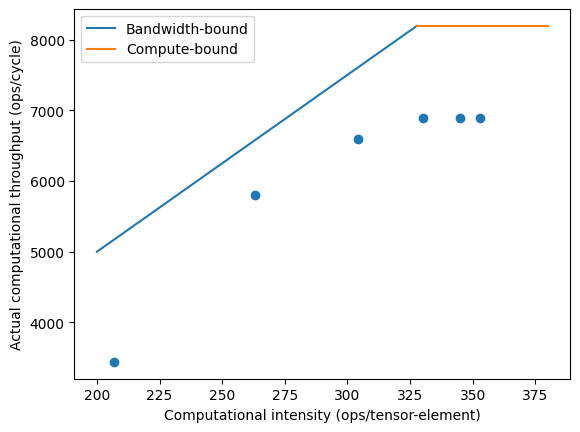

In [45]:
# Assume a convolutional layer with the following shape
input_shape = {"N": 4, "C": 64, "H": 24, "W": 24}

filter_shape = {"C": 64, "M": 128, "R": 3, "S": 3}

throughput = 8*1024 # 8,192 ops/cycle
bandwidth = 25      # 25 tensor-element/cycle

computational_intensities = []
actual_throughputs = []
for N in [1, 2, 4, 8, 16, 32]:
    input_shape["N"] = N
    spec = af.Spec.from_yaml(
        "./specs/conv.workload.yaml",
        "./specs/simple.arch.yaml",
        jinja_parse_data={"N": N}
    )
    spec.mapper.metrics = Metrics.LATENCY
    mapping_result = af.mapper.FFM.map_workload_to_arch(spec)
    num_conv_ops = conv_ops(input_shape, filter_shape)
    latency = mapping_result["Total<SEP>latency"].min()*1e9
    actual_throughput = num_conv_ops/latency
    actual_throughputs.append(actual_throughput)
    data_movement = min_conv_data_movement(input_shape, filter_shape)
    computational_intensity = num_conv_ops/data_movement
    computational_intensities.append(computational_intensity)

import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.scatter(computational_intensities, actual_throughputs)

MIN_CI = 200
MAX_CI = 380
ax.plot(
    [MIN_CI, roofline_transition(throughput, bandwidth)],
    [MIN_CI*bandwidth, throughput],
    label="Bandwidth-bound"
)
ax.plot(
    [roofline_transition(throughput, bandwidth), MAX_CI],
    [throughput, throughput],
    label="Compute-bound"
)
ax.set_xlabel("Computational intensity (ops/tensor-element)")
ax.set_ylabel("Actual computational throughput (ops/cycle)")
ax.legend()

Please answer the following question.

In [46]:
answer(
    "3.3.1",
    "True/False: actual computational throughputs always lie on the roofline.",
    required_type=bool,
    answer= False,
)

3.3.1: True/False: actual computational throughputs always lie on the roofline.
	False


## Concluding Lab 1

As we can see, a naive roofline model assumes away certain factors that impact latency and energy, which accelforge models.
Thus, there is a gap between the roofline model and accelforge results.
In future labs, we will dig deeper and gain insights into these factors, which will enable us to further optimize our designs. You can also look at Equation 3.3 and Figure 6.11 in the book if you'd like to read ahead.

Also in future labs, we will look beyond estimation, and additional questions will
arise: how many energy-consuming and latency-consuming hardware actions are necessary,
and can we minimize hardware actions while processing the DNN? These questions are at
the heart of efficient DNN hardware design, and we will see many ways to answer these
questions. To incite your imagination and curiosity:
- Buffering data in memory can reduce the need to move data, saving latency and energy,
  but requires careful scheduling of operations and data movement to do effectively.
- Avoiding multiplication or addition with zero values saves latency and energy, but
  requires clever co-design of how to format the data and the hardware elements to
  handle it.
- Integration of new technologies (*e.g.*, performing computations directly in memory)
  completely removes some data movement, but requires navigation of new trade-offs
  (*e.g.*, the memories can be very expensive to write into and the types of computation
  that can be performed are limited).

**Please follow the instructions in the README to submit the lab.**